# **Sales Dip Visualization**

In [0]:
from pyspark.sql.functions import *

# Load the data
df = spark.read.csv("dbfs:/FileStore/Retail_Store_Chain_Analysis/4_final_data.csv", header=True, inferSchema=True)

# Preprocess: Extract 'Year-Month' and retain relevant columns
df = df.select("Order Date", "Product Name", "Sub-Category", "Sales") \
    .withColumn("Year-Month", concat_ws("-", year(col("Order Date")), month(col("Order Date"))))

# Compute average sales per 'Year-Month', grouped by Product Name and Sub-Category
avg_sales_df = df.groupBy("Year-Month", "Product Name", "Sub-Category") \
    .agg(avg("Sales").alias("Average Sales"))

# Compute sales dip by finding the previous month's average sales and calculating the difference
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("Product Name", "Sub-Category").orderBy("Year-Month")
avg_sales_df = avg_sales_df \
    .withColumn("Previous Avg Sales", lag("Average Sales").over(windowSpec)) \
    .withColumn("Sales Dip", round(col("Previous Avg Sales") - col("Average Sales"), 2)) \
    .filter(col("Sales Dip") > 0)  # Filter rows where a dip occurs

# Display the results
dip_by_product = avg_sales_df.select("Product Name", "Sub-Category", "Year-Month", "Sales Dip") \
    .orderBy(col("Sales Dip").desc())  # Order by highest sales dip

dip_by_product.show(truncate=False)


+--------------------------------------------------------------------------+------------+----------+---------+
|Product Name                                                              |Sub-Category|Year-Month|Sales Dip|
+--------------------------------------------------------------------------+------------+----------+---------+
|Microsoft Natural Keyboard Elite                                          |Accessories |2018-2    |452.74   |
|Global Push Button Manager's Chair, Indigo                                |Chairs      |2015-3    |451.93   |
|Kensington 4 Outlet MasterPiece Compact Power Control Center              |Appliances  |2017-4    |451.85   |
|Fellowes Bankers Box Staxonsteel Drawer File/Stacking System              |Storage     |2017-4    |448.66   |
|Global Geo Office Task Chair, Gray                                        |Chairs      |2016-4    |443.96   |
|Belkin 5 Outlet SurgeMaster Power Centers                                 |Appliances  |2017-5    |435.84   |
|

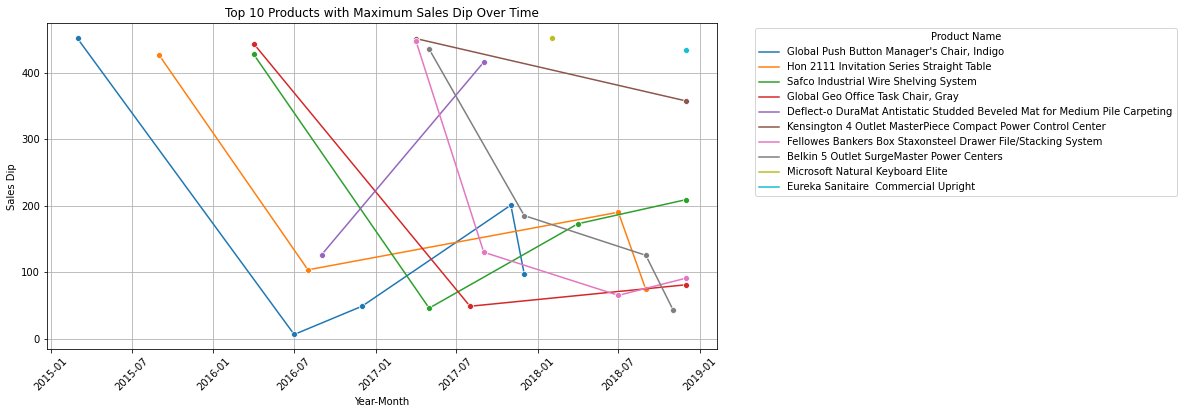

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert PySpark DataFrame to Pandas
dip_pandas_df = dip_by_product.toPandas()

# Convert 'Year-Month' to datetime format for better plotting
dip_pandas_df["Year-Month"] = pd.to_datetime(dip_pandas_df["Year-Month"], format="%Y-%m")

# Get top 10 products with the highest dip
top_10_products = dip_pandas_df.nlargest(10, "Sales Dip")["Product Name"].unique()

# Filter data to include only top 10 max dip products
dip_pandas_df = dip_pandas_df[dip_pandas_df["Product Name"].isin(top_10_products)]

# Sort values by 'Year-Month' to maintain chronological order
dip_pandas_df = dip_pandas_df.sort_values(by="Year-Month")

# Plot the sales dip over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=dip_pandas_df, x="Year-Month", y="Sales Dip", hue="Product Name", marker="o")

plt.title("Top 10 Products with Maximum Sales Dip Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Sales Dip")
plt.xticks(rotation=45)
plt.legend(title="Product Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.show()


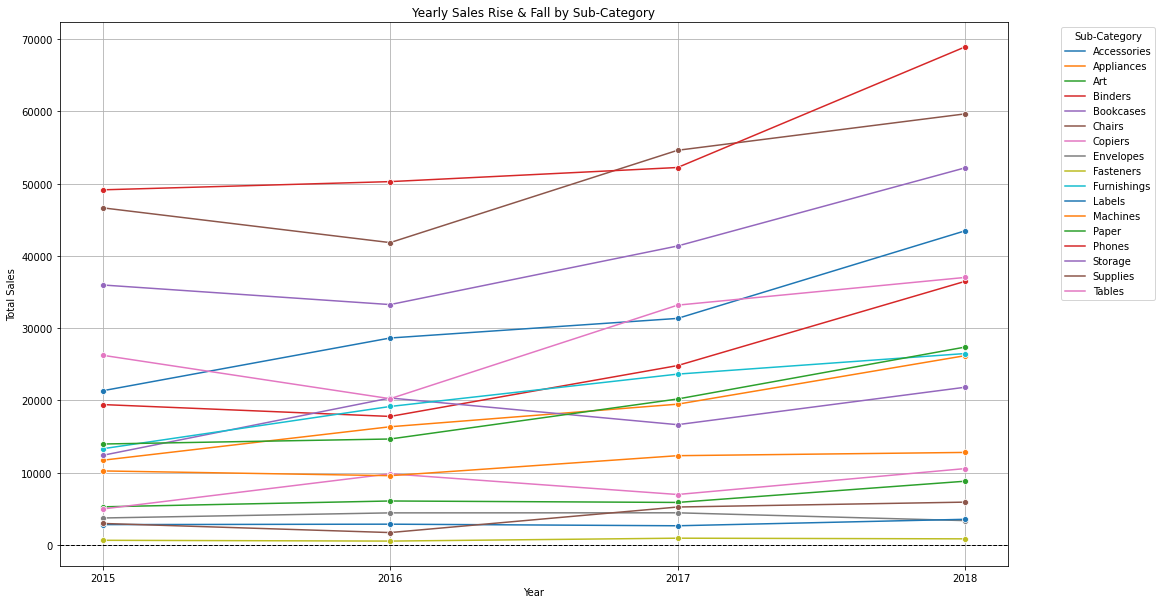

In [0]:
from pyspark.sql.functions import col, year, sum, lag, round
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Extract Year and Compute Total Sales for Each Sub-Category
subcat_sales_df = df.withColumn("Year", year(col("Order Date"))) \
    .groupBy("Year", "Sub-Category") \
    .agg(sum("Sales").alias("Total Sales")) \
    .orderBy("Year")

# Step 2: Define Window Specification for Year-wise Comparison
windowSpec = Window.partitionBy("Sub-Category").orderBy("Year")

# Step 3: Compute Sales Difference (Current Year - Previous Year)
subcat_sales_df = subcat_sales_df.withColumn("Previous Year Sales", lag("Total Sales").over(windowSpec)) \
    .withColumn("Sales Difference", round(col("Total Sales") - col("Previous Year Sales"), 2))

# Convert to Pandas for Visualization
sales_pandas_df = subcat_sales_df.toPandas()

# Convert 'Year' to integer for proper plotting
sales_pandas_df["Year"] = sales_pandas_df["Year"].astype(int)

# Step 4: Plot the Sub-Category Sales Trend
plt.figure(figsize=(17, 10))
sns.lineplot(data=sales_pandas_df, x="Year", y="Total Sales", hue="Sub-Category", marker="o", linestyle="-", palette="tab10")

# Fix X-axis to show only 2015-2018
plt.xticks([2015, 2016, 2017, 2018])

# Add a reference line at 0 to indicate no change
plt.axhline(0, color='black', linestyle="--", linewidth=1)

# Titles and labels
plt.title("Yearly Sales Rise & Fall by Sub-Category")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend(title="Sub-Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.show()
